## AirBNB Analysis: Seattle 2023 Data
#### By Darcy McCusker
In this notebook, I will take a look at some of the datasets that AirBNB makes available about bookings in Seattle. The questions I want to answer are:
> 1. What neighborhoods have the highest average prices?
> 2. What neighborhoods have the highest average reviews?
> 3. What predicts price? 

For more information about the process of exploring the data, see the AirBNB_exploration notebook elsewhere in this repository. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import datetime as dt
%matplotlib inline

list_df = pd.read_csv('listings.csv.gz', compression='gzip')
cal_df = pd.read_csv('calendar.csv.gz', compression='gzip')

In [2]:
list_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6606,https://www.airbnb.com/rooms/6606,20231220185704,2023-12-21,city scrape,Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...,NaN,"A peaceful yet highly accessible neighborhood,...",https://a0.muscache.com/pictures/45742/21116d7...,14942,...,4.76,4.88,4.57,str-opli-19-002622,f,2,2,0,0,0.91
1,9419,https://www.airbnb.com/rooms/9419,20231220185704,2023-12-20,city scrape,Rental unit in Seattle · ★4.72 · 1 bedroom · 1...,NaN,"Lots of restaurants (see our guide book) bars,...",https://a0.muscache.com/pictures/56645186/e5fb...,30559,...,4.90,4.67,4.66,STR-OPLI-19-003039,f,9,0,9,0,1.19
2,9531,https://www.airbnb.com/rooms/9531,20231220185704,2023-12-20,city scrape,Home in Seattle · ★4.97 · 2 bedrooms · 3 beds ...,NaN,The neighborhood is awesome! Just far enough ...,https://a0.muscache.com/pictures/30470355/052c...,31481,...,4.95,4.98,4.91,STR-OPLI-19-002182,f,2,2,0,0,0.59
3,9534,https://www.airbnb.com/rooms/9534,20231220185704,2023-12-20,city scrape,Guest suite in Seattle · ★4.99 · 2 bedrooms · ...,NaN,The neighborhood is the best of two worlds...w...,https://a0.muscache.com/pictures/30476721/0751...,31481,...,4.99,4.96,4.95,STR-OPLI-19-002182,f,2,2,0,0,0.52
4,9596,https://www.airbnb.com/rooms/9596,20231220185704,2023-12-21,previous scrape,Rental unit in Seattle · ★4.56 · 1 bedroom · 4...,NaN,"if you arrive early for check in at 3, I reco...",https://a0.muscache.com/pictures/665252/102d18...,14942,...,4.66,4.91,4.56,STR -OPLI-19-002622,f,2,2,0,0,0.63


In [3]:
list_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6882 entries, 0 to 6881
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6882 non-null   int64  
 1   listing_url                                   6882 non-null   object 
 2   scrape_id                                     6882 non-null   int64  
 3   last_scraped                                  6882 non-null   object 
 4   source                                        6882 non-null   object 
 5   name                                          6882 non-null   object 
 6   description                                   0 non-null      float64
 7   neighborhood_overview                         5013 non-null   object 
 8   picture_url                                   6882 non-null   object 
 9   host_id                                       6882 non-null   i

In [4]:
cal_df.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,6606,2023-12-21,f,$90.00,NaN,30.0,1125.0
1,6606,2023-12-22,f,$90.00,NaN,30.0,1125.0
2,6606,2023-12-23,t,$90.00,NaN,30.0,1125.0
3,6606,2023-12-24,t,$90.00,NaN,30.0,1125.0
4,6606,2023-12-25,t,$90.00,NaN,30.0,1125.0


In [5]:
cal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512306 entries, 0 to 2512305
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  float64
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 134.2+ MB


The listing dataframe is missing price data, which will be necessary to answer questions 1 and 3. The calendar database has complete price data. One important limitation: calendar data is future-oriented while listing data is past-oriented. It's possible that the price increases for a listing in the future beyond what it was priced at in the listing data. However, the the two source of data mostly agree on price, so this is not a major concern. With that said, let's get the missing price info from cal_df into a new version of the list_df. First, let's clean up the prices in cal_df.

In [6]:
cal_df['price_float'] = cal_df['price'].str.split("$").str[1]
cal_df['price_float'] = cal_df['price_float'].str.replace(",","")
cal_df['price_float'] = cal_df['price_float'].astype('float64')

In [7]:
df3 = cal_df.groupby('listing_id').mean().reset_index()

In [8]:
merged_df = list_df.merge(df3, left_on='id', right_on='listing_id')

In [9]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6882 entries, 0 to 6881
Data columns (total 80 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6882 non-null   int64  
 1   listing_url                                   6882 non-null   object 
 2   scrape_id                                     6882 non-null   int64  
 3   last_scraped                                  6882 non-null   object 
 4   source                                        6882 non-null   object 
 5   name                                          6882 non-null   object 
 6   description                                   0 non-null      float64
 7   neighborhood_overview                         5013 non-null   object 
 8   picture_url                                   6882 non-null   object 
 9   host_id                                       6882 non-null   i

In [10]:
merged_df['price_float'].isnull().sum()

0

Excellent. There are no missing prices in this new merged dataframe. With complete pricing info, let's look at the most expensive neighborhoods. 

### 1. What neighborhoods have the highest average prices?
Knowing the highest priced neighborhoods is important for both AirBNB and their providers, the hosts. If you're a new host, it's helpful to know what the going rate for a listing in your neighborhood actually is. From AirBNB's perspective, it's good to know where the highest priced neighborhoods are, because if they can encourage more listings in those neighborhoods especially, they can increase their revenue, as they get a higher amount of expensive listings, even if the proportion of their cut stays the same. 

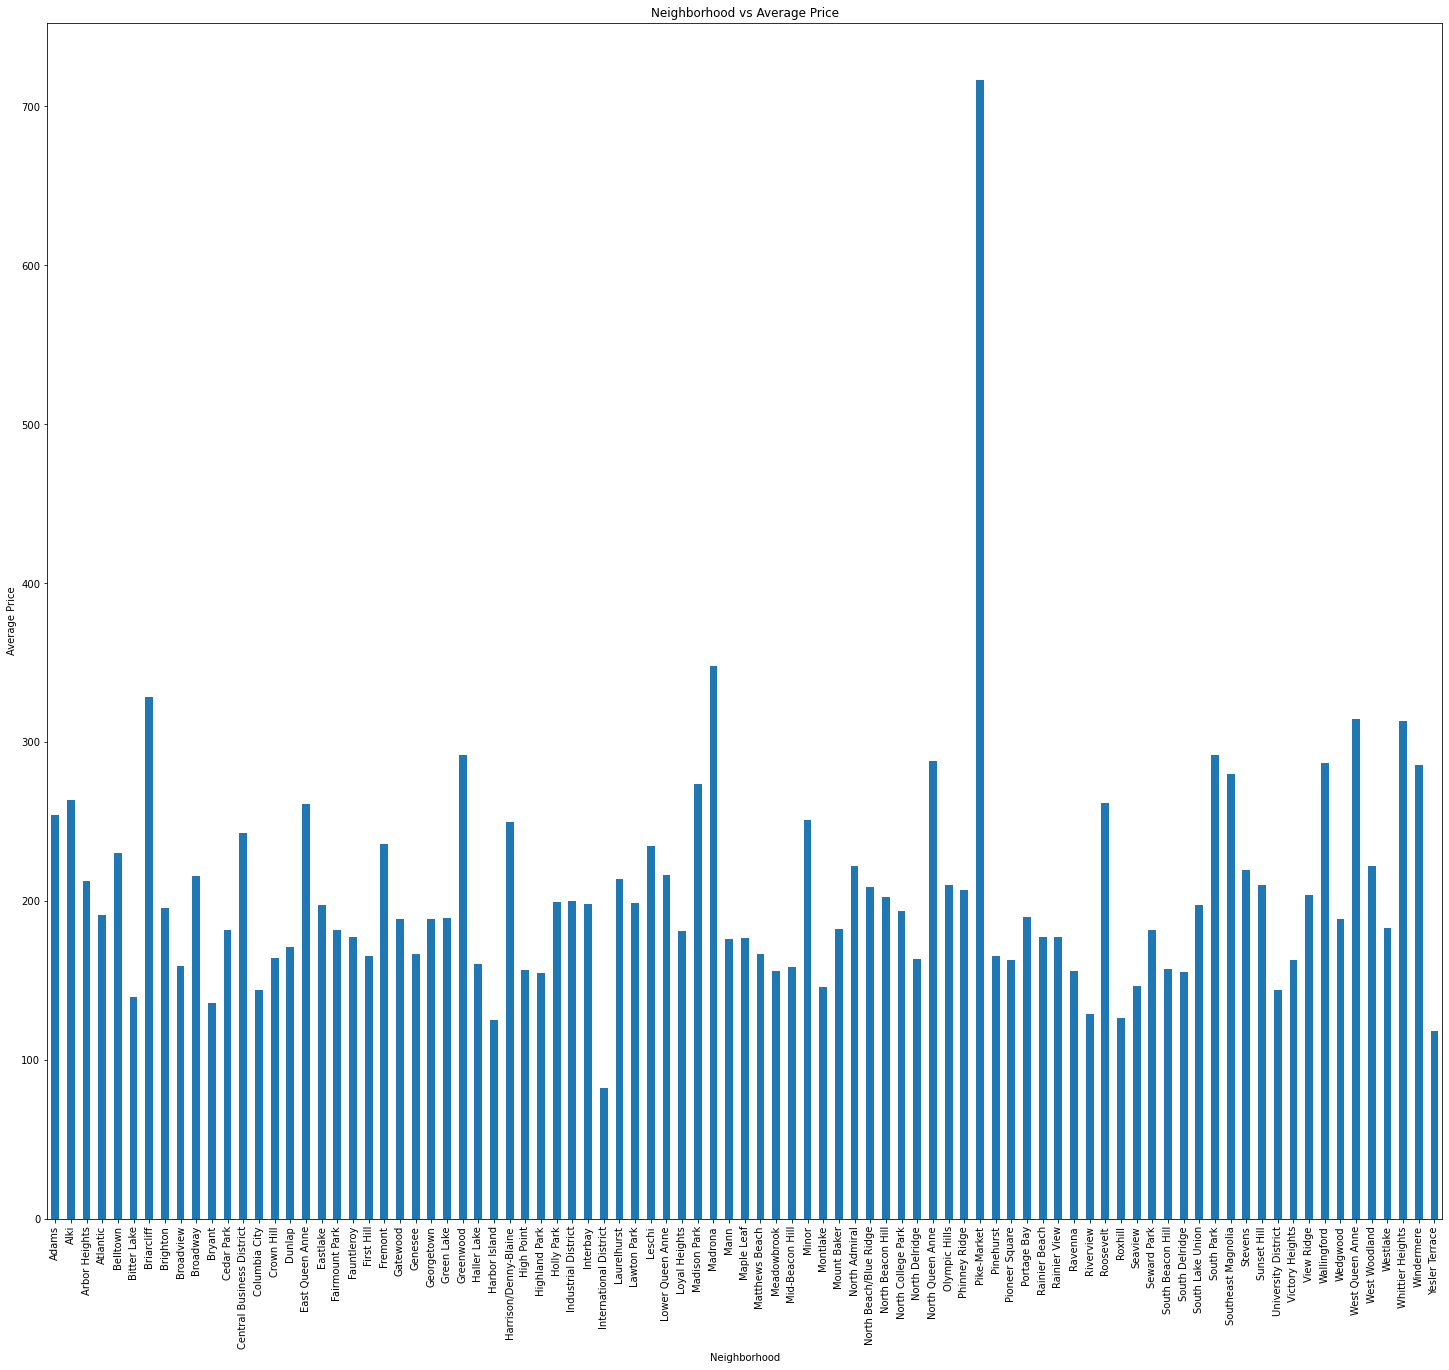

In [11]:
grouped_df = merged_df.groupby("neighbourhood_cleansed")['price_float'].mean()
grouped_df.plot.bar(figsize=(25,22),title = f"Neighborhood vs Average Price", xlabel = "Neighborhood", ylabel = (f'Average Price'));

In [12]:
merged_df.groupby("neighbourhood_cleansed")['price_float'].mean().sort_values()

neighbourhood_cleansed
International District     81.928571
Yesler Terrace            118.405797
Harbor Island             125.000000
Roxhill                   126.333333
Riverview                 129.085106
                             ...    
Whittier Heights          313.056338
West Queen Anne           314.709402
Briarcliff                328.588235
Madrona                   348.100000
Pike-Market               716.783784
Name: price_float, Length: 89, dtype: float64

Wow! Pike Market has much, much higher prices. I'm a Seattle local, which helps me interpret some of the data here. Pike-Market is closest to the major tourist destinations of the city: Pike Place Market (as the name suggests) and the waterfront, plus Seattle Center is a short monorail ride away. I can see how this part of town would command higher prices. The second and third most expensive neighborhoods are Madrona and Briarcliff. Both are expensive places to live, although neither are particularly close to downtown. 

Some of the least expensive neighborhoods include Yesler Terrace and the International District. Both neighborhoods are close to downtown, but less expensive places to live. 

AirBNB also captures larger neighborhood groups, which should smooth out some of the particularities of small neighborhoods. 

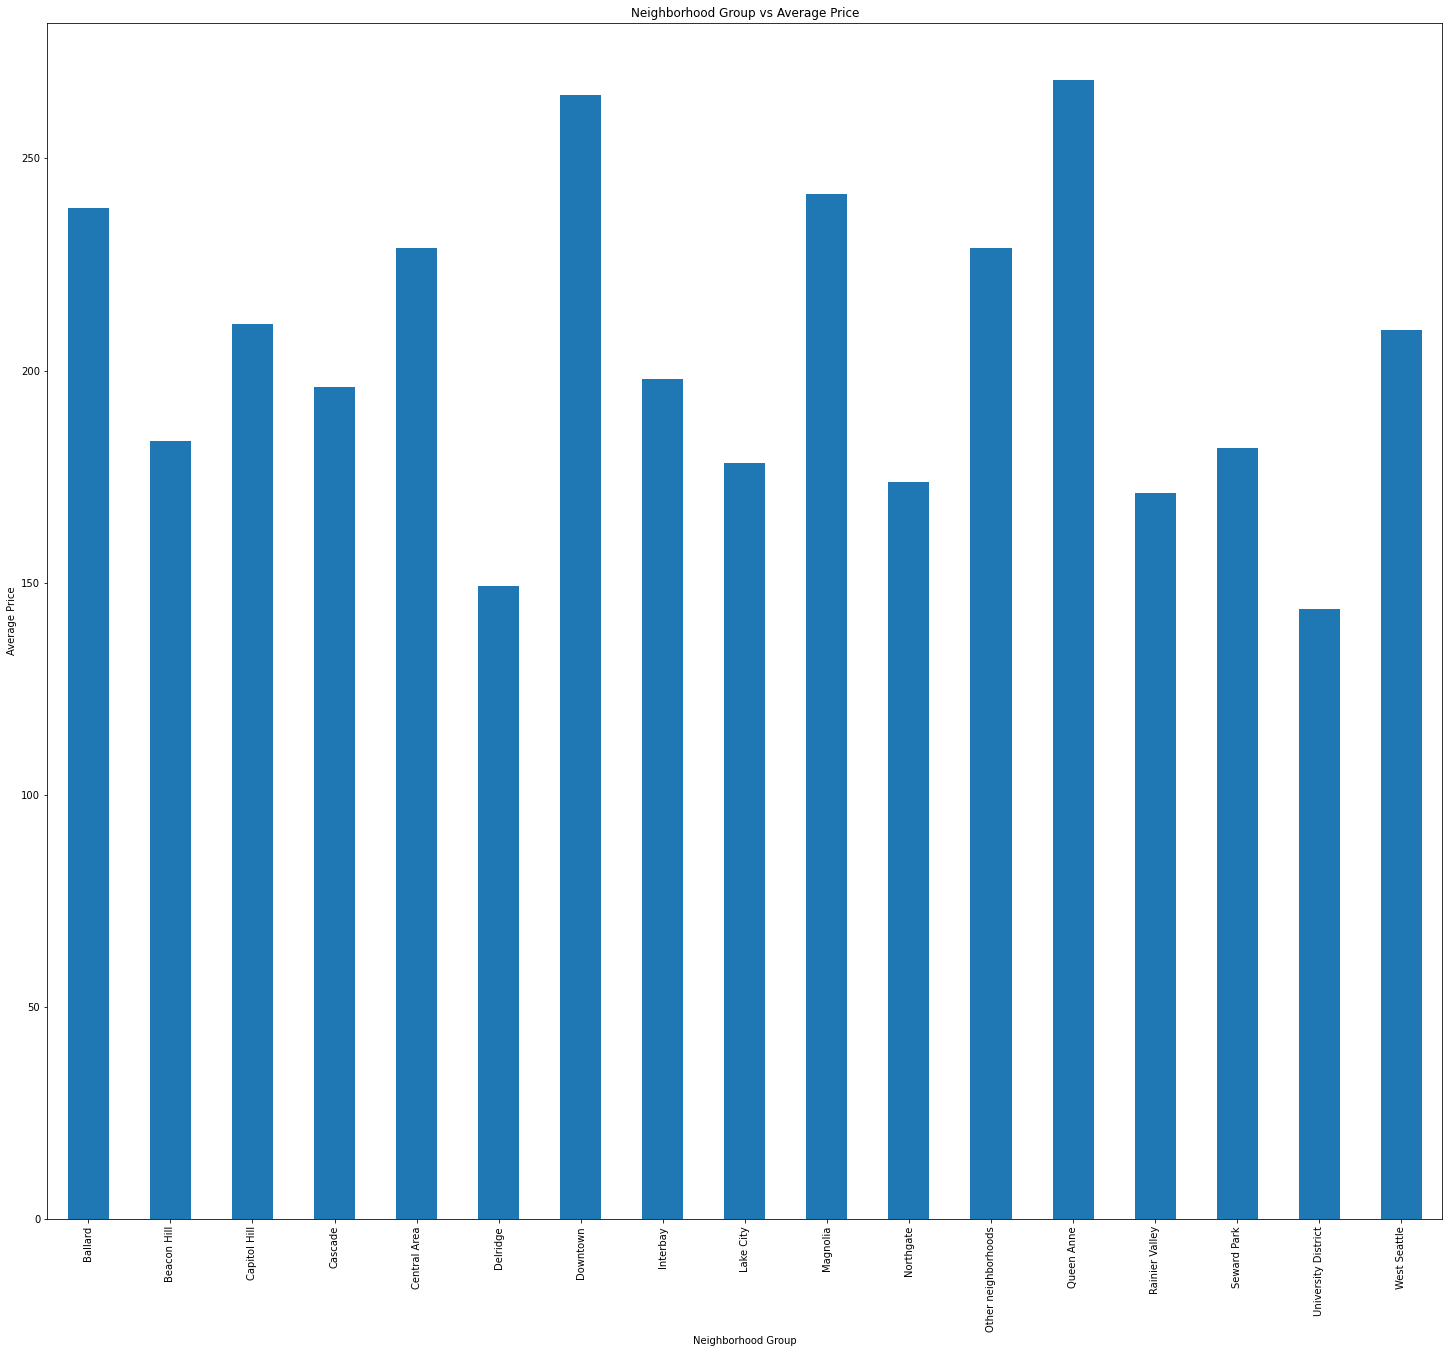

In [13]:
grouped_df = merged_df.groupby("neighbourhood_group_cleansed")['price_float'].mean()
grouped_df.plot.bar(figsize=(25,22),title = f"Neighborhood Group vs Average Price", xlabel = "Neighborhood Group", ylabel = (f'Average Price'));

In [14]:
merged_df.groupby("neighbourhood_group_cleansed")['price_float'].mean().sort_values()

neighbourhood_group_cleansed
University District    143.777293
Delridge               149.113208
Rainier Valley         171.216146
Northgate              173.745614
Lake City              178.162602
Seward Park            181.827586
Beacon Hill            183.455516
Cascade                196.143357
Interbay               198.047619
West Seattle           209.565591
Capitol Hill           211.052033
Other neighborhoods    228.784961
Central Area           228.808130
Ballard                238.408983
Magnolia               241.495413
Downtown               265.039939
Queen Anne             268.456693
Name: price_float, dtype: float64

Queen Anne and Downtown neighborhoods are at the top, while Delridge and University District are at the bottom. 

The type of listing may also be driving price. Let's look at prices for whole units, as opposed to private or shared rooms in an apartment or house. Whole units represent 84% of all listings. 

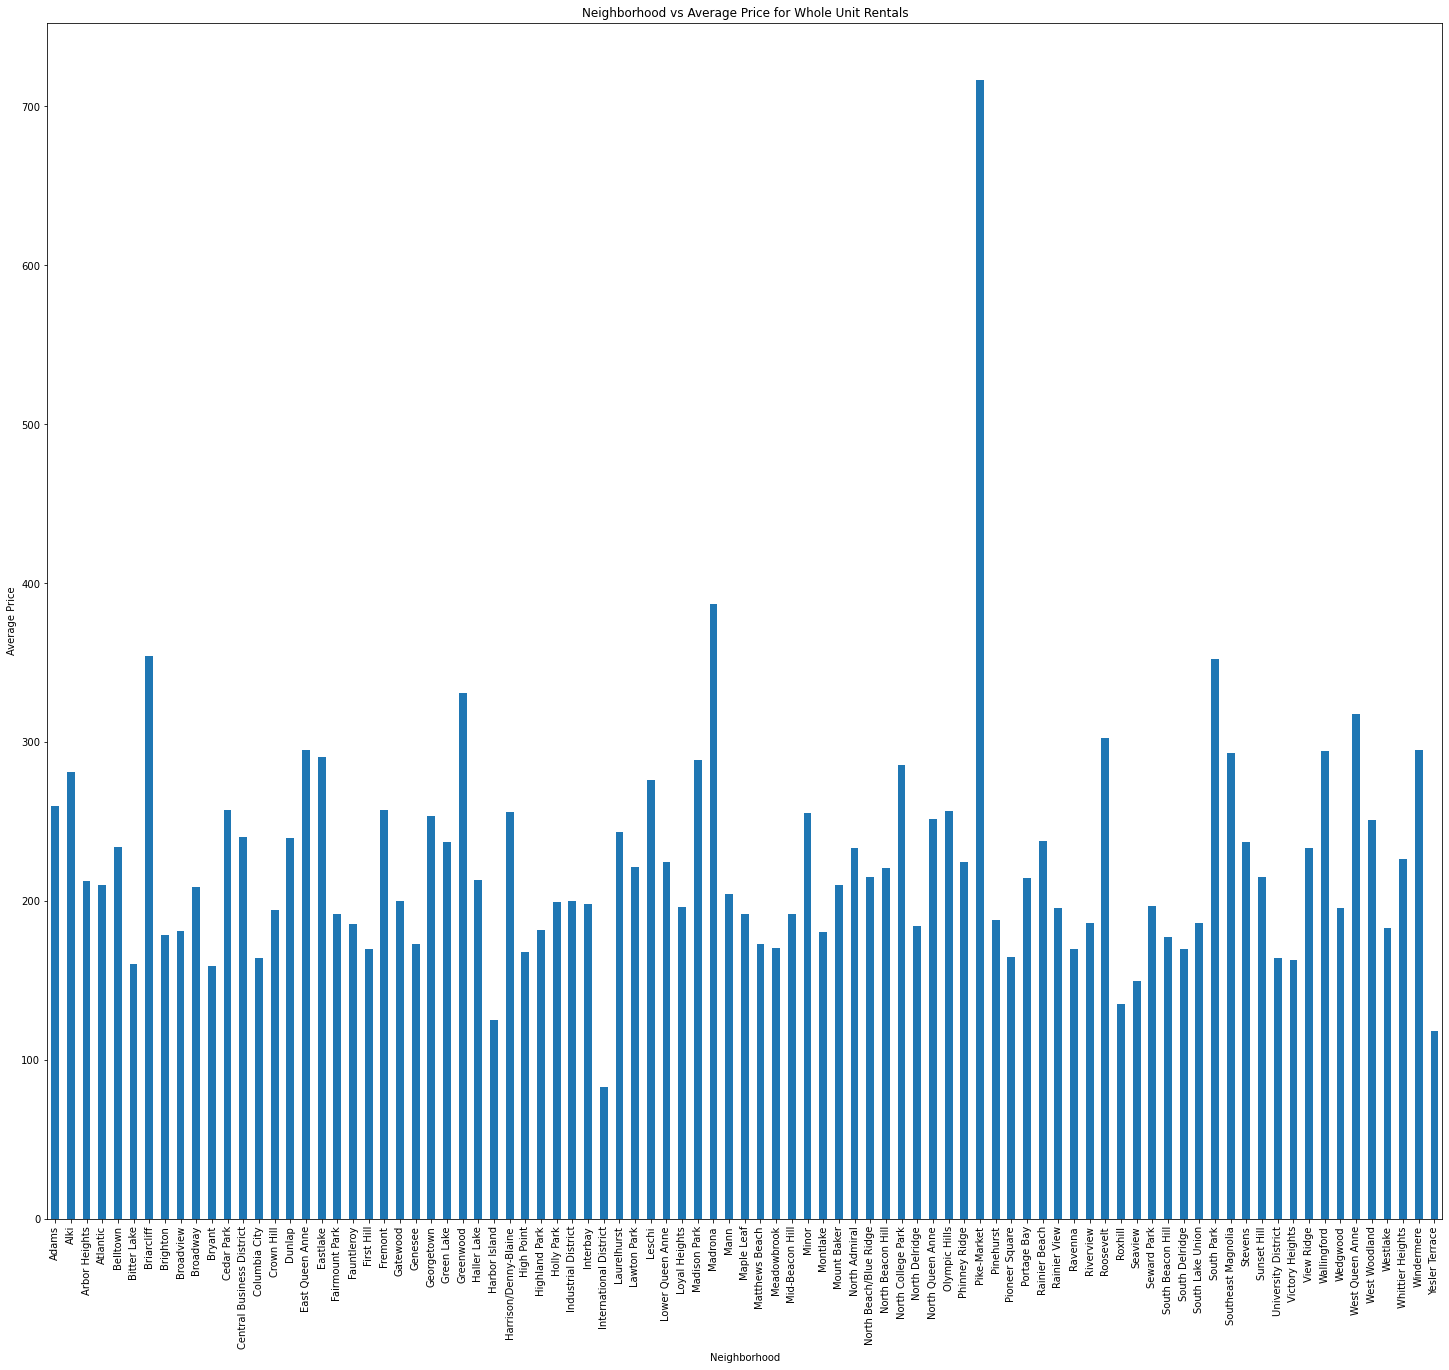

In [15]:
whole_units_df = merged_df[merged_df["room_type"] == "Entire home/apt"]
grouped_df = whole_units_df.groupby("neighbourhood_cleansed")['price_float'].mean()
grouped_df.plot.bar(figsize=(25,22),title = f"Neighborhood vs Average Price for Whole Unit Rentals", xlabel = "Neighborhood", ylabel = (f'Average Price'));

In [16]:
whole_units_df.groupby("neighbourhood_cleansed")['price_float'].mean().sort_values()

neighbourhood_cleansed
International District     83.000000
Yesler Terrace            118.405797
Harbor Island             125.000000
Roxhill                   135.153846
Seaview                   149.742857
                             ...    
Greenwood                 330.964029
South Park                352.304348
Briarcliff                354.400000
Madrona                   387.028571
Pike-Market               716.783784
Name: price_float, Length: 89, dtype: float64

It actually tells a quite similar story! Pike Market is still dominant, with Madrona and Briarcliff still in second and third. The ID and Yesler Terrace are still quite low. 

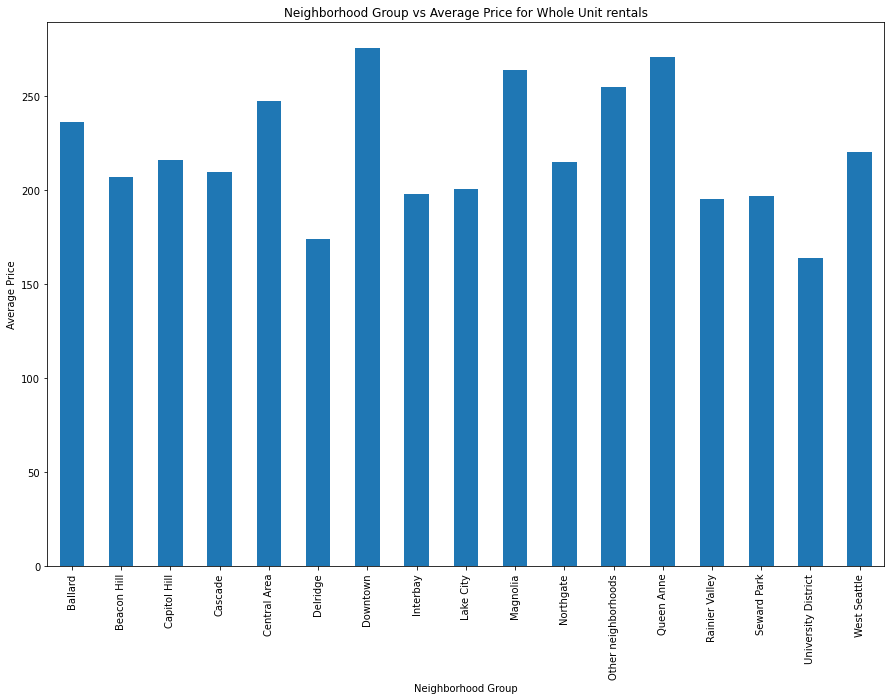

In [17]:
grouped_df = whole_units_df.groupby("neighbourhood_group_cleansed")['price_float'].mean()
grouped_df.plot.bar(figsize=(15,10),title = f"Neighborhood Group vs Average Price for Whole Unit rentals", xlabel = "Neighborhood Group", ylabel = (f'Average Price'));

In [18]:
whole_units_df.groupby("neighbourhood_group_cleansed")['price_float'].mean().sort_values()

neighbourhood_group_cleansed
University District    164.051429
Delridge               174.185185
Rainier Valley         195.260714
Seward Park            196.788462
Interbay               198.047619
Lake City              200.281553
Beacon Hill            207.090129
Cascade                209.666667
Northgate              214.740741
Capitol Hill           216.148221
West Seattle           220.251748
Ballard                236.336022
Central Area           247.438878
Other neighborhoods    254.785411
Magnolia               263.914894
Queen Anne             270.651316
Downtown               275.353541
Name: price_float, dtype: float64

Including only whole units, Downtown and Queen Anne are still at the top, but Magnolia (an expensive neighborhood) and the catch-all other neighborhoods category have moved up above the $250/night mark. UDistrict and Delridge still remain at the bottom. 

Why does this matter? As a host, this information gives a rough guideline for how to price a unit, especially if you have a whole unit that is similar to many others in your neighborhood or neighborhood group. For AirBNB, as long as demand is high, it would be worthwhile to incentivize more listings in the highest price neighborhoods to increase profits.  


### 2. What neighborhoods have the highest average reviews?
Now that we know where the highest priced neighborhoods are, let's look at how well each neighborhood is reviewed. Again, this is important information for hosts and AirBNB. Hosts will want to know how their new listings might fare, while AirBNB wants to be able to identify if there are any neighborhoods that guests continually rate as very good (or very bad). 

We'll look only at neighborhoods that have at least ten reviews, to make sure one very good or very bad review (or a neighborhood without any reviews whatsoever, as is the case for Harbor Island) doesn't skew the overall trends. 

In [19]:
merged_df['review_count'] = merged_df.groupby('neighbourhood_cleansed')['review_scores_rating'].transform('count')
ten_reviews_df = merged_df[merged_df['review_count'] >= 10]


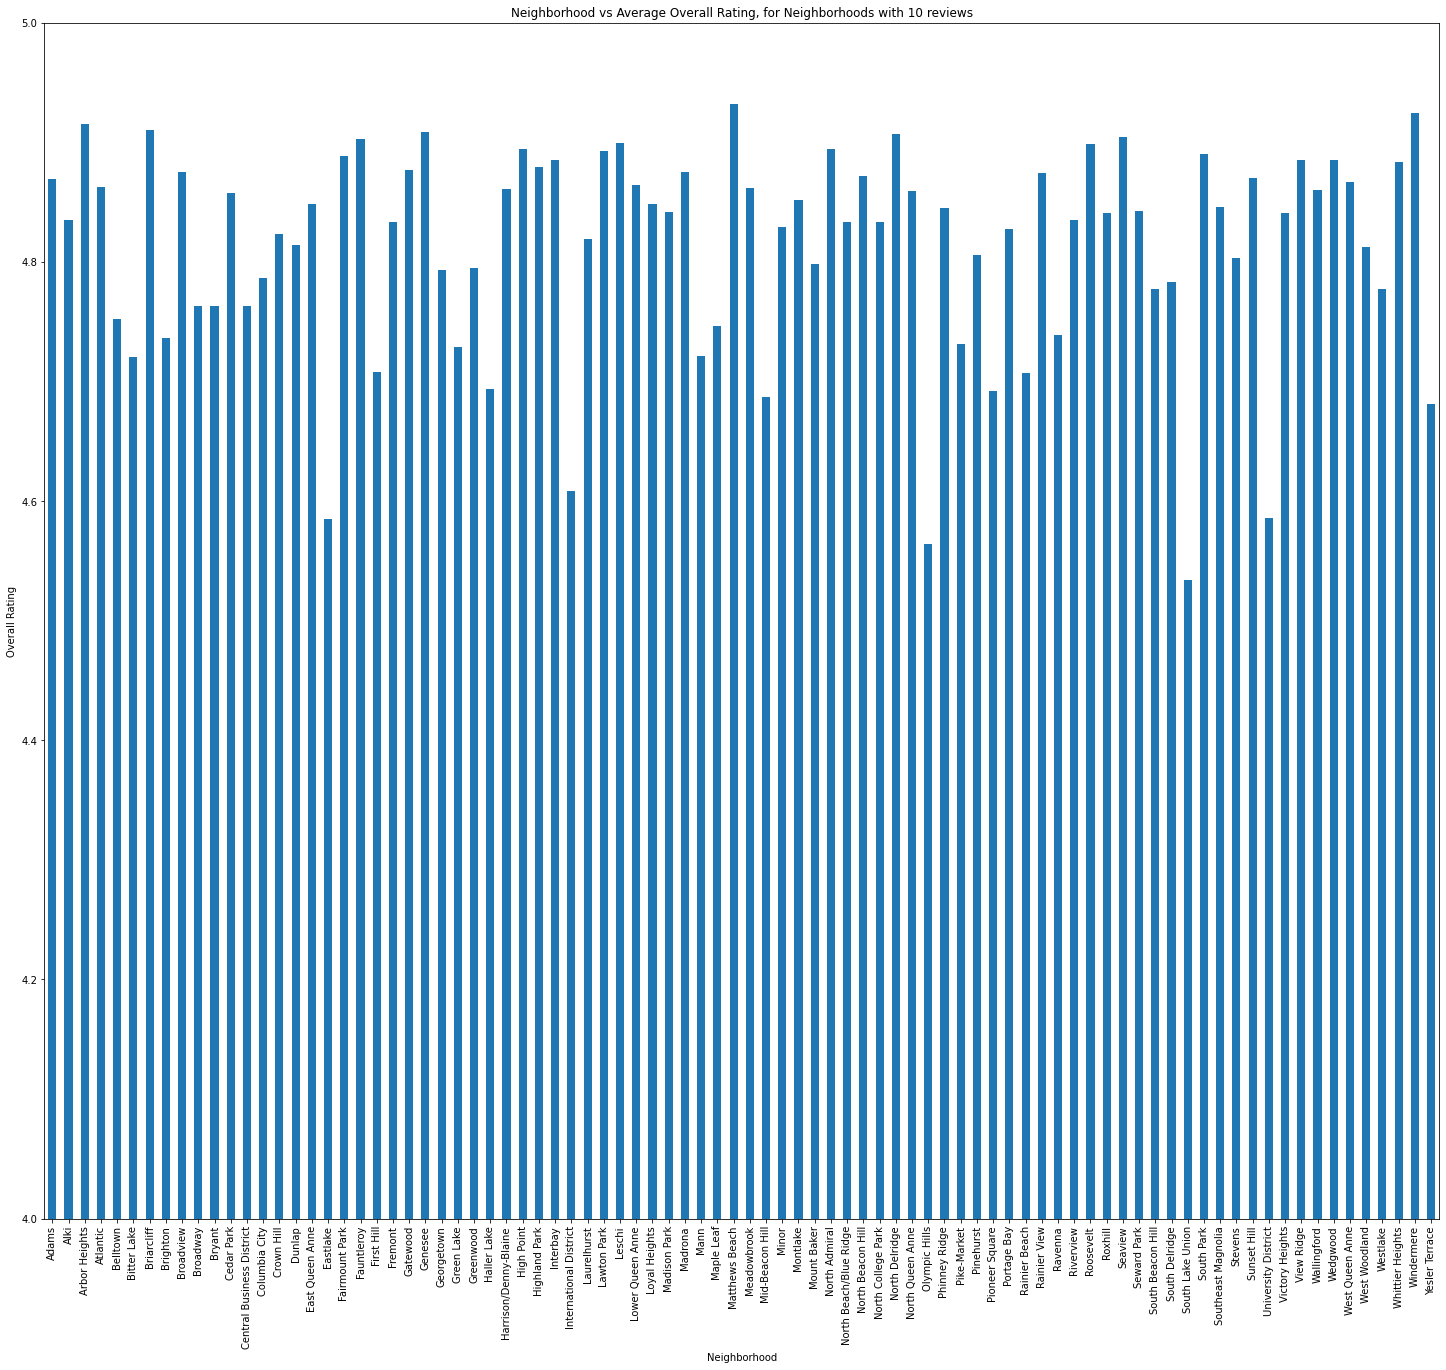

In [20]:
grouped_df = ten_reviews_df.groupby("neighbourhood_cleansed")['review_scores_rating'].mean()
grouped_df.plot.bar(figsize=(25,22),title = f"Neighborhood vs Average Overall Rating, for Neighborhoods with 10 reviews", xlabel = "Neighborhood", ylabel = (f'Overall Rating'))
plt.ylim(4,5);


In [21]:
ten_reviews_df.groupby("neighbourhood_cleansed")['review_scores_rating'].mean().sort_values()

neighbourhood_cleansed
South Lake Union          4.533939
Olympic Hills             4.564000
Eastlake                  4.585088
University District       4.585619
International District    4.608148
                            ...   
Genesee                   4.908788
Briarcliff                4.910714
Arbor Heights             4.915238
Windermere                4.924167
Matthews Beach            4.931786
Name: review_scores_rating, Length: 86, dtype: float64

Nobody likes South Lake Union very much (sorry, Amazon)! Matthews Beach, Windermere, and Arbor Heights are the best neighborhoods by overall reviews. Let's check for neighborhood groups as well. 

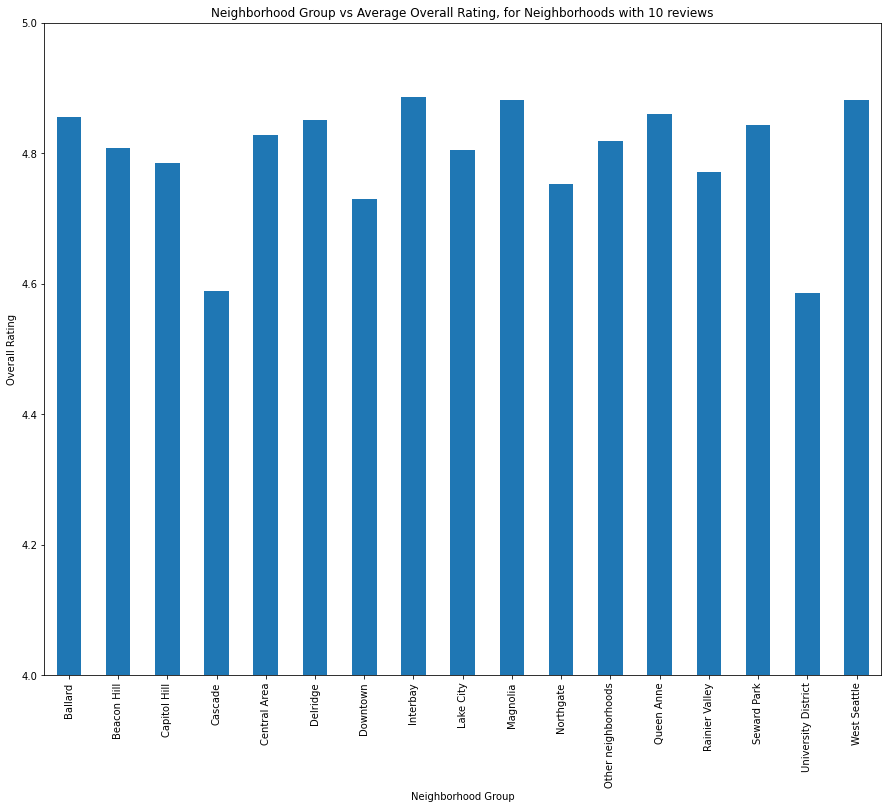

In [22]:
grouped_df = ten_reviews_df.groupby("neighbourhood_group_cleansed")['review_scores_rating'].mean()
grouped_df.plot.bar(figsize=(15,12),title = f"Neighborhood Group vs Average Overall Rating, for Neighborhoods with 10 reviews", xlabel = "Neighborhood Group", ylabel = (f'Overall Rating'))
plt.ylim(4,5);

In [23]:
ten_reviews_df.groupby("neighbourhood_group_cleansed")['review_scores_rating'].mean().sort_values()

neighbourhood_group_cleansed
University District    4.585619
Cascade                4.588392
Downtown               4.730294
Northgate              4.753232
Rainier Valley         4.771723
Capitol Hill           4.784283
Lake City              4.805556
Beacon Hill            4.807413
Other neighborhoods    4.819353
Central Area           4.828004
Seward Park            4.842778
Delridge               4.851144
Ballard                4.855041
Queen Anne             4.859512
West Seattle           4.881000
Magnolia               4.881800
Interbay               4.885385
Name: review_scores_rating, dtype: float64

Interbay, Magnolia, and West Seattle have the highest scores overall, while UDistrict, Cascade, and Downtown have the lowest. 
Let's look at average review scores specific to location. 

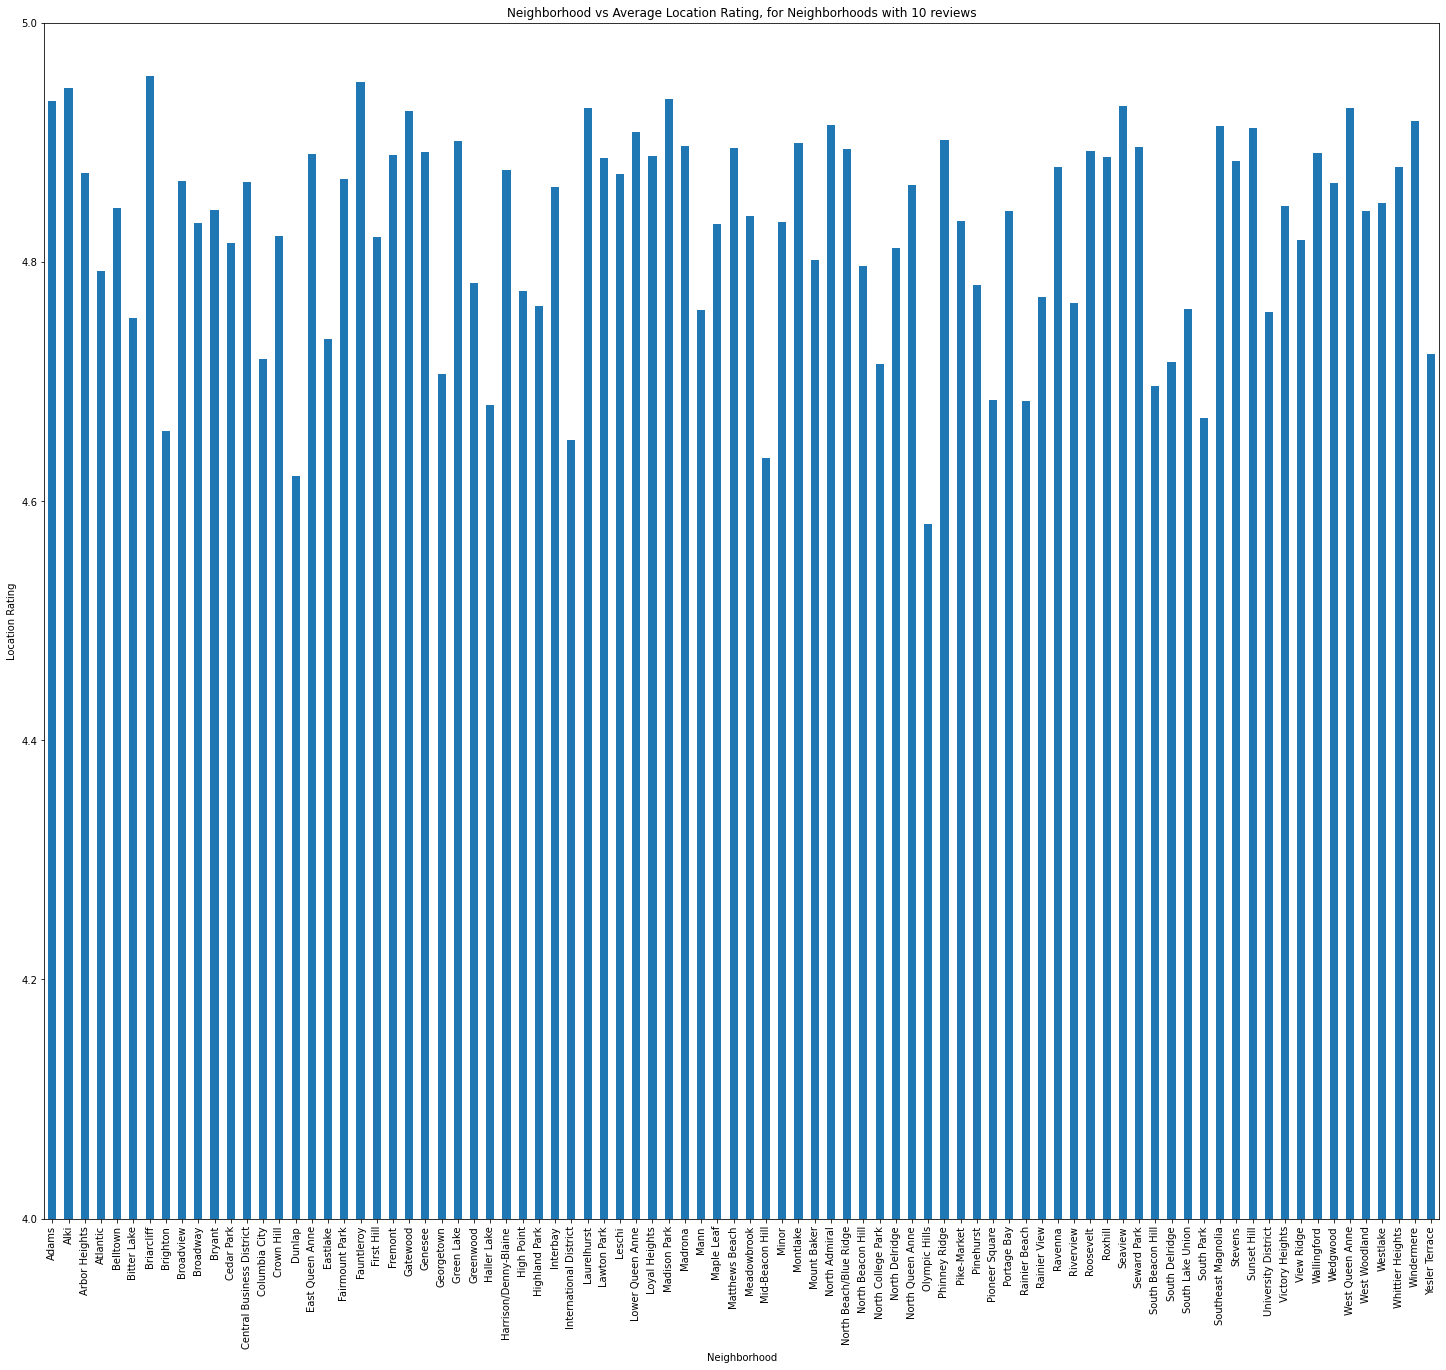

In [24]:
grouped_df = ten_reviews_df.groupby("neighbourhood_cleansed")['review_scores_location'].mean()
grouped_df.plot.bar(figsize=(25,22),title = f"Neighborhood vs Average Location Rating, for Neighborhoods with 10 reviews", xlabel = "Neighborhood", ylabel = (f'Location Rating'))
plt.ylim(4,5);

In [25]:
ten_reviews_df.groupby("neighbourhood_cleansed")['review_scores_location'].mean().sort_values()

neighbourhood_cleansed
Olympic Hills             4.581200
Dunlap                    4.621154
Mid-Beacon Hill           4.636197
International District    4.651481
Brighton                  4.658281
                            ...   
Adams                     4.934476
Madison Park              4.936154
Alki                      4.945048
Fauntleroy                4.950294
Briarcliff                4.955714
Name: review_scores_location, Length: 86, dtype: float64

Briarcliff, Alki, and Fauntleroy are all neighborhoods on cliffs near the Puget Sound; I can only imagine how good the views are! None of these neighborhoods are near tourist places, though. I happen to like Olympic Hills, but it's not exactly scenic. 

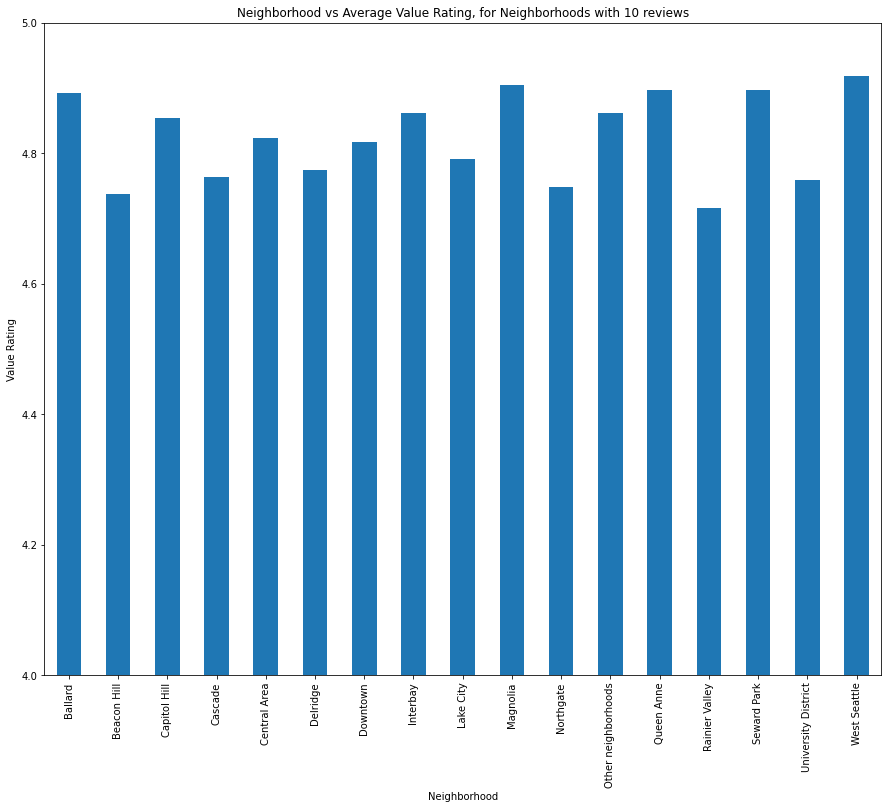

In [26]:
grouped_df = ten_reviews_df.groupby("neighbourhood_group_cleansed")['review_scores_location'].mean()
grouped_df.plot.bar(figsize=(15,12),title = f"Neighborhood vs Average Value Rating, for Neighborhoods with 10 reviews", xlabel = "Neighborhood", ylabel = (f'Value Rating'))
plt.ylim(4,5);

In [27]:
ten_reviews_df.groupby("neighbourhood_group_cleansed")['review_scores_location'].mean().sort_values()

neighbourhood_group_cleansed
Rainier Valley         4.716158
Beacon Hill            4.737838
Northgate              4.748939
University District    4.758381
Cascade                4.763147
Delridge               4.773483
Lake City              4.791296
Downtown               4.817871
Central Area           4.823041
Capitol Hill           4.853745
Interbay               4.862308
Other neighborhoods    4.862371
Ballard                4.891836
Seward Park            4.896111
Queen Anne             4.897256
Magnolia               4.904500
West Seattle           4.918571
Name: review_scores_location, dtype: float64

By neighborhood group, West Seattle, Magnolia, and Queen Anne have the best location ratings. Rainier Valley, Beacon Hill, and Northgate have some of the lowest. 

Let's look at how travelers rate the value of their stays by neighborhood. 

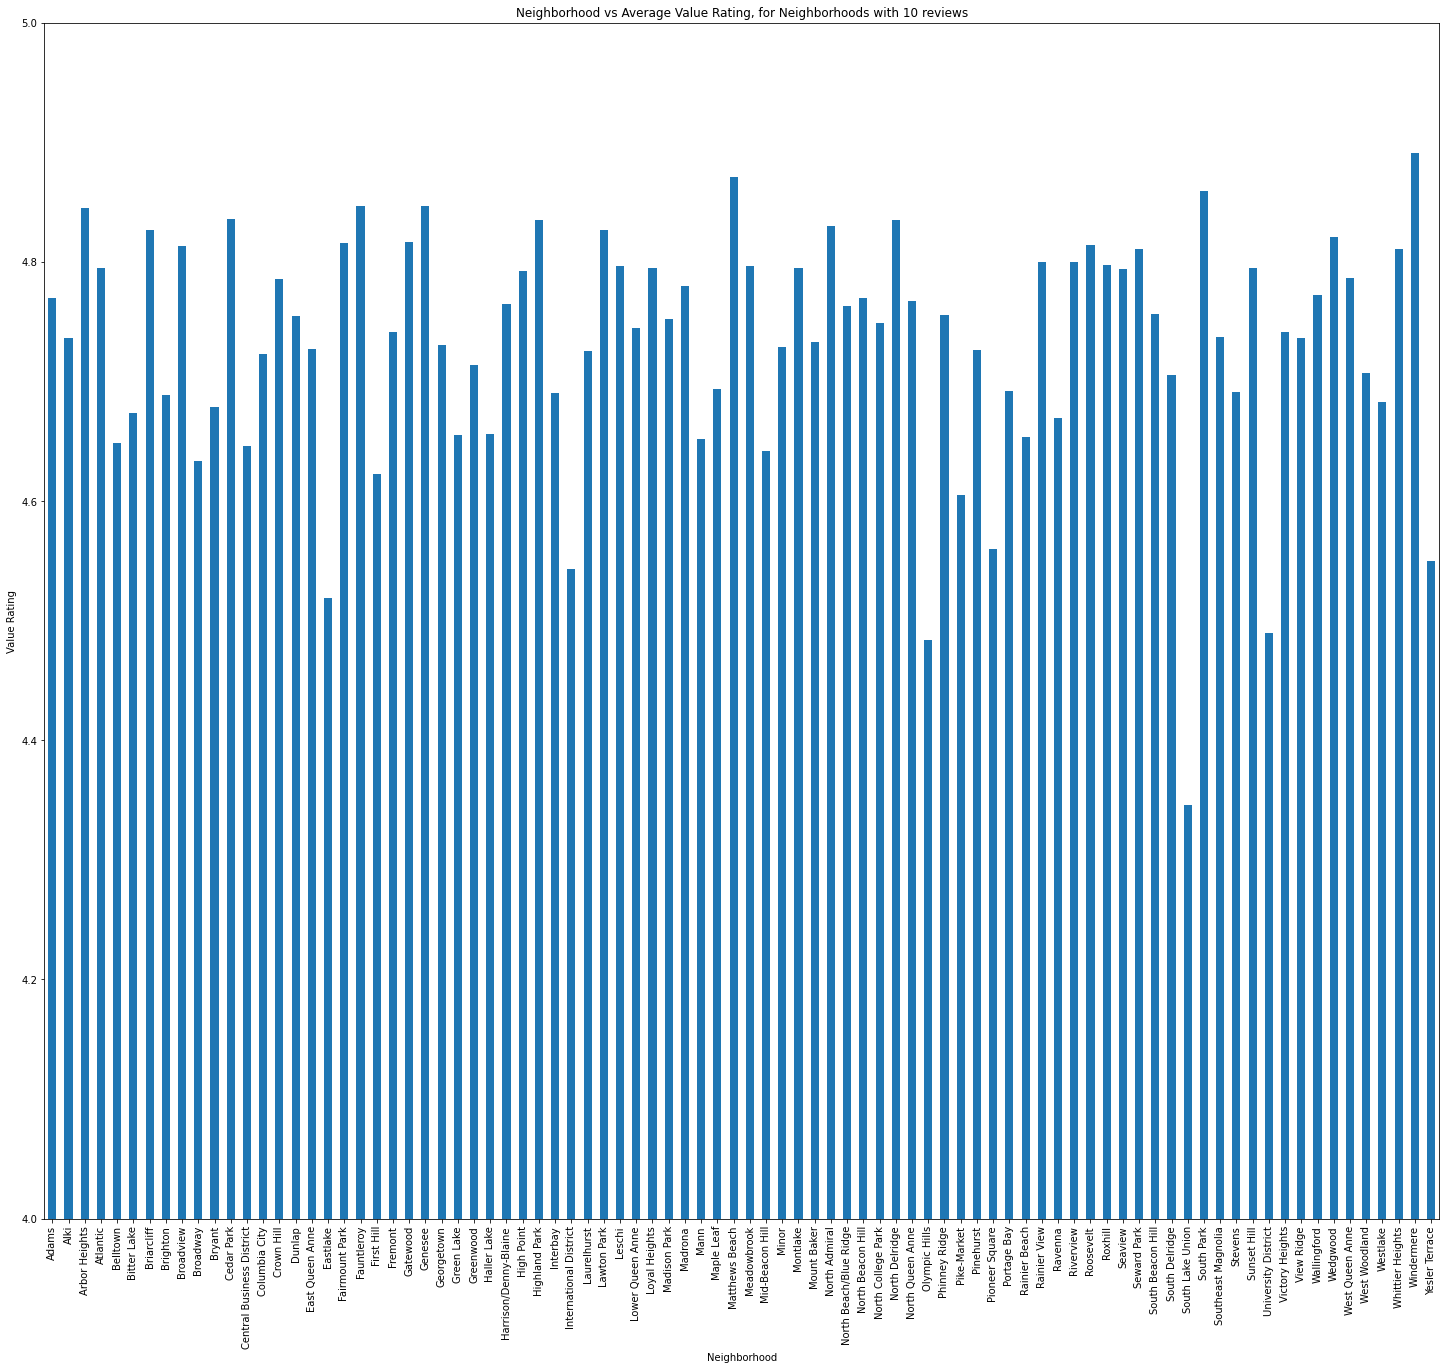

In [28]:
grouped_df = ten_reviews_df.groupby("neighbourhood_cleansed")['review_scores_value'].mean()
grouped_df.plot.bar(figsize=(25,22),title = f"Neighborhood vs Average Value Rating, for Neighborhoods with 10 reviews", xlabel = "Neighborhood", ylabel = (f'Value Rating'))
plt.ylim(4,5);

In [29]:
ten_reviews_df.groupby("neighbourhood_cleansed")['review_scores_value'].mean().sort_values()

neighbourhood_cleansed
South Lake Union          4.345692
Olympic Hills             4.484000
University District       4.489952
Eastlake                  4.519298
International District    4.542963
                            ...   
Fauntleroy                4.846471
Genesee                   4.846667
South Park                4.859200
Matthews Beach            4.871071
Windermere                4.890833
Name: review_scores_value, Length: 86, dtype: float64

Matthews Beach and Windermere are again on top, along with South Park. At the bottom is SLU (again!), Olympic Hills (again :( ) and UDistrict. 

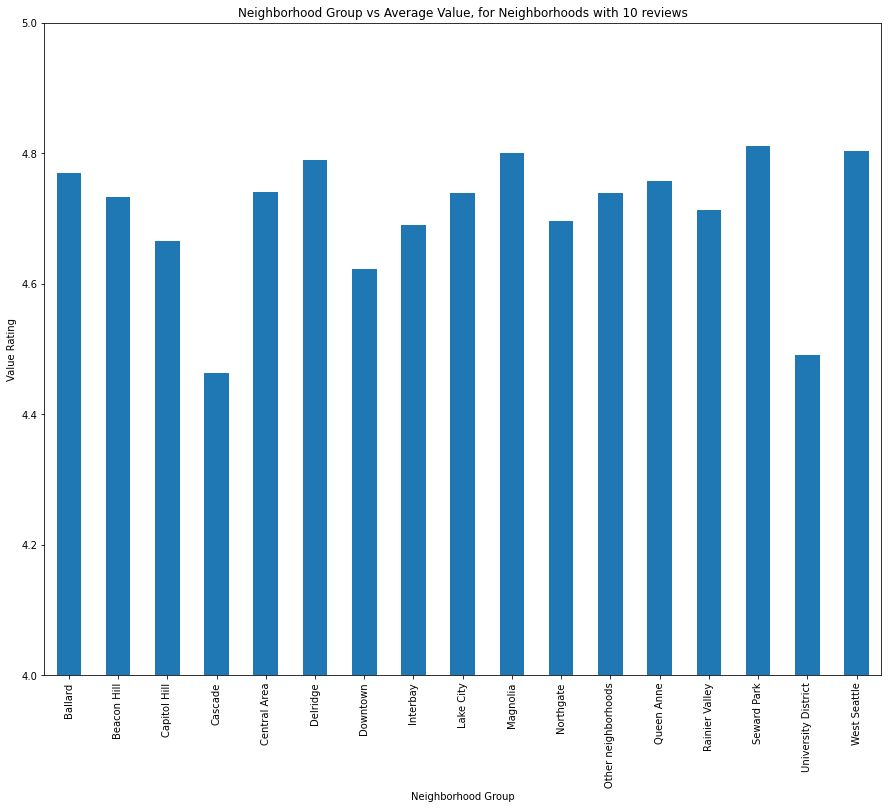

In [30]:
grouped_df = ten_reviews_df.groupby("neighbourhood_group_cleansed")['review_scores_value'].mean()
grouped_df.plot.bar(figsize=(15,12),title = f"Neighborhood Group vs Average Value, for Neighborhoods with 10 reviews", xlabel = "Neighborhood Group", ylabel = (f'Value Rating'))
plt.ylim(4,5);

In [31]:
ten_reviews_df.groupby("neighbourhood_group_cleansed")['review_scores_value'].mean().sort_values()

neighbourhood_group_cleansed
Cascade                4.462887
University District    4.489952
Downtown               4.623186
Capitol Hill           4.665976
Interbay               4.690000
Northgate              4.695808
Rainier Valley         4.712175
Beacon Hill            4.732703
Lake City              4.738611
Other neighborhoods    4.739458
Central Area           4.739851
Queen Anne             4.756791
Ballard                4.770301
Delridge               4.788905
Magnolia               4.800700
West Seattle           4.804071
Seward Park            4.810556
Name: review_scores_value, dtype: float64

### What predicts price?
Price is arguably the most important factor travelers consider when deciding where to book, all other things being equal. Both hosts and AirBNB would benefit from knowing what factors most heavily impact price and how strong the relationship is. Hosts want to set prices at a reasonable level for their properties, and if AirBNB could provide them with a formula to do so, both parties would make more money. 

One way to come up with such a formula is using a linear regression model. A model has many parameters and coefficients, where for each attribute of a property, we can fill in the correct parameters and using the coefficients to give an estimate of price. 

First, I need to prepare some of the columns for analysis then clean the data so it can be used in the linear regression model. Note that the price data is treated logarithmically. For more information about why these methods were used for cleaning the data and how this model was selected, please see the exploration notebook located elsewhere in this repository.   
##### Preparing the Data

In [32]:
merged_df['bathrooms_text'] = merged_df['bathrooms_text'].str.replace('half-bath', "0.5")
merged_df['bathrooms_text'] = merged_df['bathrooms_text'].str.replace('Half-bath', "0.5")
merged_df['no_of_bathrooms'] = merged_df['bathrooms_text'].str.extract('(\d+.?\d*)').astype(float)
merged_df['shared_bathroom'] = merged_df['bathrooms_text'].str.contains('shared').astype(int)

In [33]:
def clean_data_log(df, x, y):
    '''
    INPUT
    df - pandas dataframe 
    x - list of columns to include as variables 
    y - the dependent variable being predicted 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Create y as the log of the input y
    2. Create X using the provided set of columns in x
    3. For each numeric variable in X, fill the column with the mean value of the column.
    4. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    #Take the log of the column specified in y
    y = np.log10(df[y])
    
    #Create a df with just the relevant columns 
    df = df[x]
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y


In [34]:
X, y = clean_data_log(merged_df,["neighbourhood_cleansed","room_type","accommodates","beds","minimum_nights_avg_ntm","maximum_nights_avg_ntm","review_scores_rating",
"review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value",
"instant_bookable","no_of_bathrooms","shared_bathroom"] , 'price_float')

C:\Users\Darcy\AppData\Local\Temp\ipykernel_31128\408291192.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].fillna((df[col].mean()), inplace=True)


##### Running the Model 
Now that we have our cleaned data, let's divide it into a training set to build the model and a testing set to check the fit of the model. 

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Four steps:

#Instantiate
lm_model = LinearRegression() 

#Fit 
lm_model.fit(X_train, y_train) 

#Predict and score the model
y_test_preds = lm_model.predict(X_test) 

#Rsquared and y_test
rsquared_score = r2_score(y_test, y_test_preds)
length_y_test = len(y_test)

"The r-squared score for your model was {} on {} values.".format(rsquared_score, length_y_test)

'The r-squared score for your model was 0.45029355683720906 on 2065 values.'

Not too bad! The included attributes can explain 45% of the variation in price. This means there are other factors (possibly contained in the listing dataset, but also possibly outside of the data collected) that are also factoring into the price. However, getting a linear model like this gives AirBNB and hosts a great start for figuring out how to price rentals. 

Now, let's look at some of the coefficients of the model to see what coefficients are contributing the most weight to the model. 

In [36]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df


In [37]:
coef_df = coef_weights(lm_model.coef_, X_train)
coef_df.head(25)

,est_int,coefs,abs_coefs
83,neighbourhood_cleansed_South Beacon Hill,-0.247777,0.247777
80,neighbourhood_cleansed_Roxhill,-0.242919,0.242919
102,room_type_Shared room,-0.230261,0.230261
71,neighbourhood_cleansed_Pike-Market,0.215662,0.215662
27,neighbourhood_cleansed_Dunlap,-0.200505,0.200505
72,neighbourhood_cleansed_Pinehurst,-0.189402,0.189402
59,neighbourhood_cleansed_Mid-Beacon Hill,-0.187421,0.187421
78,neighbourhood_cleansed_Riverview,-0.186437,0.186437
75,neighbourhood_cleansed_Rainier Beach,-0.185510,0.185510
26,neighbourhood_cleansed_Crown Hill,-0.179690,0.179690


The coefficients themselves are harder to intepret, since we need to raise each to the tenth power to find the actual change in price, but the direction is clear. More outlying neighborhoods drive the price down, while more central ones increase the price. Pike Place commands much higher prices, while neighborhoods like Mid and South Beacon Hill and Roxhill lower the price substantially. Some of the bougie neighborhoods actually lower the price, but some raise it (compare Wedgwood to Madrona; both are fancy neighborhood, but one lowers the price and one raises it). But most of the neighborhoods that lower the price are further from downtown or are otherwise inconvenient if you want to go to the major tourist attractions in Seattle. 

But this model represents a way to give AirBNB and hosts a formula for setting prices on a new listing. Given neighborhood, number of beds, number of bathrooms, room type, review scores and a few other factors, this formula will predict a property's price. 